# MIMIC-IV

This notebook provides a few tables and figures which describe data elements in MIMIC-IV. In order to use the notebook you'll need to configure the Google Cloud SDK to run queries. An easy way to do this is to [auth the gcloud CLI](https://cloud.google.com/sdk/docs/authorizing). You will also need to use a Google account which has been granted access to query MIMIC-IV v2.0. See the [cloud access page](https://mimic.mit.edu/docs/gettingstarted/cloud/) on the MIMIC documentation.

In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tableone import TableOne

## Hospital stay demographics

In [2]:
hosp = pd.read_gbq("""
SELECT
      pat.subject_id
    , adm.hadm_id
    , DENSE_RANK() OVER hadm_window AS hosp_stay_num
    , CASE
        WHEN FIRST_VALUE(adm.hadm_id) OVER hadm_window = adm.hadm_id THEN 1
        ELSE 0
      END AS pat_count
    , pat.anchor_age + (EXTRACT(YEAR FROM adm.admittime) - pat.anchor_year) AS age
    , pat.gender
    , adm.insurance
    , DATETIME_DIFF(adm.dischtime, adm.admittime, HOUR) / 24 AS hosp_los
    , pat.dod
    , DATE_DIFF(pat.dod, CAST(adm.dischtime AS DATE), DAY) AS days_to_death
    -- mortality flags
    , CASE WHEN DATE_DIFF(pat.dod, CAST(adm.dischtime AS DATE), DAY) = 0 THEN 1 ELSE 0 END AS hospital_mortality
FROM `physionet-data.mimiciv_hosp.patients` pat
INNER JOIN `physionet-data.mimiciv_hosp.admissions` adm
    ON pat.subject_id = adm.subject_id
WINDOW hadm_window AS (PARTITION BY pat.subject_id ORDER BY adm.admittime)
""", "lcp-internal")

# add 1 year mortality
hosp['one_year_mortality'] = hosp['days_to_death'].notnull().astype(int)

# create a dataframe with the days to death for only the last ICU stay
last_dod = hosp.groupby('subject_id')[['hosp_stay_num']].max().reset_index()
last_dod = last_dod.merge(hosp[['subject_id', 'hosp_stay_num', 'days_to_death']], on=['subject_id', 'hosp_stay_num'], how='inner')
last_dod.rename(columns={'days_to_death': 'days_to_death_last_stay_id'}, inplace=True)

hosp = hosp.merge(last_dod, how='left', on=['subject_id', 'hosp_stay_num'])
del last_dod
hosp.sort_values(['subject_id', 'hosp_stay_num'], inplace=True)

# fix some data type issues
int_cols = hosp.dtypes.values=="Int64"
hosp.loc[:, int_cols] = hosp.loc[:, int_cols].astype(float)
hosp.loc[:, int_cols] = hosp.loc[:, int_cols].astype(int, errors="ignore")

/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/geopandas/_compat.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_GE_10 = str(pd.__version__) >= LooseVersion("1.0.0")
/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/geopandas/_compat.py:19: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_GE_11 = str(pd.__version__) >= LooseVersion("1.1.0")
/Users/alistairewj/min

## ICU demographics

In [3]:
data = pd.read_gbq("""
SELECT
      pat.subject_id
    , adm.hadm_id
    , icu.stay_id
    , ROW_NUMBER() OVER (PARTITION BY pat.subject_id ORDER BY icu.intime) AS icu_stay_num
    , DENSE_RANK() OVER (PARTITION BY pat.subject_id ORDER BY adm.admittime) AS hosp_stay_num
    , CASE
        WHEN FIRST_VALUE(icu.stay_id) OVER icustay_window = icu.stay_id THEN 1
        ELSE 0
      END AS pat_count
    , pat.anchor_age + (EXTRACT(YEAR FROM icu.intime) - pat.anchor_year) AS age
    , pat.gender
    , adm.insurance
    , icu.first_careunit
    , icu.los AS icu_los
    , DATETIME_DIFF(adm.dischtime, adm.admittime, HOUR) / 24 AS hosp_los
    , pat.dod
    , DATE_DIFF(pat.dod, CAST(adm.dischtime AS DATE), DAY) AS days_to_death
    -- mortality flags
    , CASE WHEN DATE_DIFF(pat.dod, CAST(adm.dischtime AS DATE), DAY) = 0 THEN 1 ELSE 0 END AS hospital_mortality
    , CASE WHEN DATE_DIFF(pat.dod, CAST(icu.outtime AS DATE), DAY) = 0 THEN 1 ELSE 0 END AS icu_mortality
FROM `physionet-data.mimiciv_hosp.patients` pat
INNER JOIN `physionet-data.mimiciv_hosp.admissions` adm
    ON pat.subject_id = adm.subject_id
INNER JOIN `physionet-data.mimiciv_icu.icustays` icu
    ON adm.hadm_id = icu.hadm_id
WINDOW hadm_window AS (PARTITION BY pat.subject_id ORDER BY adm.admittime)
     , icustay_window AS (PARTITION BY pat.subject_id ORDER BY icu.intime)
""", "lcp-internal")

# add 1 year mortality
data['one_year_mortality'] = data['days_to_death'].notnull().astype(int)

# create a dataframe with the days to death for only the last ICU stay
last_dod = data.groupby('subject_id')[['icu_stay_num']].max().reset_index()
last_dod = last_dod.merge(data[['subject_id', 'icu_stay_num', 'days_to_death']], on=['subject_id', 'icu_stay_num'], how='inner')
last_dod.rename(columns={'days_to_death': 'days_to_death_last_stay_id'}, inplace=True)

data = data.merge(last_dod, how='left', on=['subject_id', 'icu_stay_num'])
del last_dod
data.sort_values(['subject_id', 'icu_stay_num'], inplace=True)

# add a grouping variable for table one so we can have hospital mortality as a group and a row
data['hosp_mort'] = data['hospital_mortality']

# fix some data type issues
int_cols = data.dtypes.values=="Int64"
data.loc[:, int_cols] = data.loc[:, int_cols].astype(float)
data.loc[:, int_cols] = data.loc[:, int_cols].astype(int, errors="ignore")

In [4]:
columns = [
    "pat_count",
    # , "hadm_count",
    "age", "gender", "insurance",
    # "first_careunit",
    # "icu_los",
    "hosp_los",
    # 'icu_mortality',
    'hospital_mortality',
    "one_year_mortality",
    # "days_to_death_last_stay_id"
]

categorical = [
    "pat_count",
    # "hadm_count",
    "gender", "insurance",
    # "first_careunit",
    # mortality flags
    # 'icu_mortality',
    'hospital_mortality',
    'one_year_mortality',
]

order = {
    "pat_count": [1, 0],
    "hadm_count": [1, 0],
    "gender": ["F", "M"],
    # "icu_mortality": [1, 0],
    "hospital_mortality": [1, 0],
    "one_year_mortality": [1, 0],
}

limit = {
    "pat_count": 1, "hadm_count": 1,
    "gender": 1,
    # "icu_mortality": 1,
    "hospital_mortality": 1,
    "one_year_mortality": 1,
}

rename = {
    "pat_count": "Distinct patients", "hadm_count": "Distinct hospitalizations",
    "age": "Age", "gender": "Administrative Gender", "insurance": "Insurance",
    "first_careunit": "First ICU stay, unit type",
    "icu_los": "ICU length of stay", "hosp_los": "Hospital length of stay",
    "icu_mortality": "In-ICU mortality",
    "hospital_mortality": "In-hospital mortality",
    "one_year_mortality": "One year mortality",
    # "days_to_death_last_stay_id": "Time to death (days)",
}

print('ICU demographics')
icu_table = TableOne(data, columns=columns, categorical=categorical, order=order, limit=limit, rename=rename)
display(icu_table)
print('Hospital demographics')
hosp_table = TableOne(hosp, columns=columns, categorical=categorical, order=order, limit=limit, rename=rename)
display(hosp_table)

ICU demographics


/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/tableone/tableone.py:1420: UserWarning: Order variable not found: hadm_count
  warnings.warn("Order variable not found: {}".format(k))


Missing       Overall
n                                                           76943
Distinct patients, n (%)           1              0  53569 (69.6)
Age, mean (SD)                                    0   64.7 (16.9)
Administrative Gender, n (%)       F              0  34091 (44.3)
Insurance, n (%)                   Medicaid       0    5825 (7.6)
                                   Medicare          34740 (45.2)
                                   Other             36378 (47.3)
Hospital length of stay, mean (SD)                0   11.0 (13.3)
In-hospital mortality, n (%)       1              0   8987 (11.7)
One year mortality, n (%)          1              0  29747 (38.7)

Hospital demographics


/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/tableone/tableone.py:1420: UserWarning: Order variable not found: hadm_count
  warnings.warn("Order variable not found: {}".format(k))


Missing        Overall
n                                                           454324
Distinct patients, n (%)           1              0  190279 (41.9)
Age, mean (SD)                                    0    58.7 (19.2)
Administrative Gender, n (%)       F              0  237184 (52.2)
Insurance, n (%)                   Medicaid       0    43748 (9.6)
                                   Medicare          168963 (37.2)
                                   Other             241613 (53.2)
Hospital length of stay, mean (SD)                0      4.5 (6.6)
In-hospital mortality, n (%)       1              0     9381 (2.1)
One year mortality, n (%)          1              0  112092 (24.7)

In [5]:
# generate latex table used in sci data paper
tableone_for_paper = hosp_table.tableone.drop(columns='Missing').copy()
tableone_for_paper.rename(columns={'Overall': 'Hospital stays'}, inplace=True)

tableone_for_paper = tableone_for_paper.merge(
    icu_table.tableone.drop(columns='Missing'),
    left_index=True, right_index=True, how='inner'
)
tableone_for_paper.rename(columns={'Overall': 'ICU stays'}, inplace=True)

# TODO: merge 2nd col into 1st, which we did manually
print(tableone_for_paper.to_latex())

\begin{tabular}{llll}
\toprule
                          &   & Hospital stays &     ICU stays \\
\midrule
n & {} &         454324 &         76943 \\
Distinct patients, n (\%) & 1 &  190279 (41.9) &  53569 (69.6) \\
Age, mean (SD) &   &    58.7 (19.2) &   64.7 (16.9) \\
Administrative Gender, n (\%) & F &  237184 (52.2) &  34091 (44.3) \\
Insurance, n (\%) & Medicaid &    43748 (9.6) &    5825 (7.6) \\
                          & Medicare &  168963 (37.2) &  34740 (45.2) \\
                          & Other &  241613 (53.2) &  36378 (47.3) \\
Hospital length of stay, mean (SD) &   &      4.5 (6.6) &   11.0 (13.3) \\
In-hospital mortality, n (\%) & 1 &     9381 (2.1) &   8987 (11.7) \\
One year mortality, n (\%) & 1 &  112092 (24.7) &  29747 (38.7) \\
\bottomrule
\end{tabular}



/var/folders/fn/qznlq4rd1sn88j6llg9sqk1m0000gn/T/ipykernel_5638/4092134405.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tableone_for_paper.to_latex())


## Summary figures

In [6]:
# find a good example patient
query = """
SELECT t.hadm_id
from `physionet-data.mimiciv_hosp.admissions` t
where 
-- has more than one icu stay for the hospitalization
t.hadm_id IN (select hadm_id from `physionet-data.mimiciv_icu.icustays` group by 1 having count(*) > 1)
AND 
-- has heparin admin
t.hadm_id IN (SELECT DISTINCT hadm_id FROM `physionet-data.mimiciv_hosp.emar` WHERE LOWER(medication) LIKE '%drug%')
AND
-- did not die
deathtime IS NULL
-- maybe in trauma?
"""
df = pd.read_gbq(query, 'lcp-internal')
# manually looked through df for an hadm_id which was visually appealing

In [7]:
# hadm_id we extract / plot data for

hadm_id = 28503629
# above hadm_id - cardiac arrest in community
# CCU on 2164-11-09T17:40:00
# then got CABG and admitted to CVICU on 11-19
# then discharged home

## Extract data

Run SQL against BigQuery to grab dataframes with `hadm_id` specific data.

In [8]:
# === laboratory derived datasets
query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(bg.charttime, a.admittime, MINUTE) AS offset
    , bg.po2 AS pao2
    , bg.pco2 AS paco2
    , bg.ph
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_derived.bg` bg
  ON a.hadm_id = bg.hadm_id
WHERE a.hadm_id = {hadm_id}
AND bg.specimen = 'ART.'
"""
bg = pd.read_gbq(query, "lcp-internal")
bg.sort_values('offset', inplace=True)

query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(c.charttime, a.admittime, MINUTE) AS offset
    , albumin
    , globulin
    , total_protein
    , aniongap
    , bicarbonate
    , bun
    , calcium
    , chloride
    , creatinine
    , glucose
    , sodium
    , potassium
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_derived.chemistry` c
  ON a.hadm_id = c.hadm_id
WHERE a.hadm_id = {hadm_id}
"""
chem = pd.read_gbq(query, "lcp-internal")
chem.sort_values('offset', inplace=True)

query = f"""
WITH trop AS
(
    SELECT specimen_id, MAX(valuenum) AS troponin_t
    FROM `physionet-data.mimiciv_hosp.labevents`
    WHERE itemid = 51003
    GROUP BY specimen_id
)
SELECT
    a.hadm_id
    , DATETIME_DIFF(c.charttime, a.admittime, MINUTE) AS offset
    , trop.troponin_t
    , c.ntprobnp
    , c.ck_mb
FROM `physionet-data.mimiciv_hosp.admissions` a
LEFT JOIN `physionet-data.mimiciv_derived.cardiac_marker` c
  ON a.hadm_id = c.hadm_id
LEFT JOIN trop
  ON c.specimen_id = trop.specimen_id
WHERE a.hadm_id = {hadm_id}
"""
cardiac = pd.read_gbq(query, "lcp-internal")
cardiac.sort_values('offset', inplace=True)

query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(cbc.charttime, a.admittime, MINUTE) AS offset
    , cbc.wbc
FROM `physionet-data.mimiciv_hosp.admissions` a
LEFT JOIN `physionet-data.mimiciv_derived.complete_blood_count` cbc
ON a.hadm_id = cbc.hadm_id
WHERE a.hadm_id = {hadm_id}
"""
cbc = pd.read_gbq(query, "lcp-internal")
cbc.sort_values('offset', inplace=True)


# === icu information system derived dataframes
query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(v.charttime, a.admittime, MINUTE) AS offset
    , v.heart_rate, v.sbp, v.dbp
    , v.sbp_ni, v.dbp_ni
    , v.resp_rate
    , v.temperature
    , v.spo2
    , v.glucose
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_icu.icustays` i
    ON a.hadm_id = i.hadm_id
LEFT JOIN `physionet-data.mimiciv_derived.vitalsign` v
    ON i.stay_id = v.stay_id
WHERE a.hadm_id = {hadm_id}
"""
vitals = pd.read_gbq(query, "lcp-internal")
vitals.sort_values('offset', inplace=True)

query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(v.charttime, a.admittime, MINUTE) AS offset
    , v.heart_rhythm
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_icu.icustays` i
    ON a.hadm_id = i.hadm_id
LEFT JOIN `physionet-data.mimiciv_derived.rhythm` v
    ON i.subject_id = v.subject_id
    AND v.charttime BETWEEN i.intime AND i.outtime
WHERE a.hadm_id = {hadm_id}
"""
rhythm = pd.read_gbq(query, "lcp-internal")
rhythm.sort_values('offset', inplace=True)

query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(gcs.charttime, a.admittime, MINUTE) AS offset
    , gcs.gcs_motor
    , gcs.gcs_verbal
    , gcs.gcs_eyes
    , gcs.gcs_unable
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_derived.gcs` gcs
  ON a.subject_id = gcs.subject_id
  AND gcs.charttime BETWEEN a.admittime AND a.dischtime
WHERE a.hadm_id = {hadm_id}
"""
gcs = pd.read_gbq(query, "lcp-internal")
gcs.sort_values('offset', inplace=True)

# separately extract temperature from vital signs
# the temperature vital sign as of the time of this notebook did not include arctic sun itemids
query = f"""
SELECT
    c.hadm_id
    , DATETIME_DIFF(c.charttime, a.admittime, MINUTE) AS offset
    , di.label
    , c.value
    , c.valuenum
    , c.valueuom
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_icu.chartevents` c
  ON a.hadm_id = c.hadm_id
INNER JOIN `physionet-data.mimiciv_icu.d_items` di
  ON c.itemid = di.itemid
WHERE a.hadm_id = {hadm_id}
AND c.itemid IN
(
227632, -- Arctic Sun/Alsius Temp #1 C
227634, -- Arctic Sun/Alsius Temp #2 C
223761 -- Temperature Fahrenheit
)
AND valuenum > 10 AND valuenum < 120
"""
temp = pd.read_gbq(query, "lcp-internal")
# convert farenheit
idx = temp['valueuom'].isin(['°F'])
temp.loc[idx, 'valuenum'] = (temp.loc[idx, 'valuenum'] - 32)/1.8
temp.sort_values('offset', inplace=True)

query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(inp.starttime, a.admittime, MINUTE) AS start_offset
    , DATETIME_DIFF(inp.endtime, a.admittime, MINUTE) AS end_offset
    , di.label
    , inp.rate
    , inp.amount
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_icu.icustays` i
    ON a.hadm_id = i.hadm_id
LEFT JOIN `physionet-data.mimiciv_icu.inputevents` inp
    ON i.stay_id = inp.stay_id
LEFT JOIN `physionet-data.mimiciv_icu.d_items` di
    ON inp.itemid = di.itemid
WHERE a.hadm_id = {hadm_id}
"""
inp = pd.read_gbq(query, "lcp-internal")
inp.sort_values('start_offset', inplace=True)

query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(pe.starttime, a.admittime, MINUTE) AS start_offset
    , DATETIME_DIFF(pe.endtime, a.admittime, MINUTE) AS end_offset
    , di.label
    , pe.value
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_icu.icustays` i
    ON a.hadm_id = i.hadm_id
LEFT JOIN `physionet-data.mimiciv_icu.procedureevents` pe
    ON i.stay_id = pe.stay_id
LEFT JOIN `physionet-data.mimiciv_icu.d_items` di
    ON pe.itemid = di.itemid
WHERE a.hadm_id = {hadm_id}
"""
pe = pd.read_gbq(query, "lcp-internal")
pe.sort_values('start_offset', inplace=True)


# === provider order entry (poe)

query = f"""
SELECT
    a.hadm_id
    , DATETIME_DIFF(p.ordertime, a.admittime, MINUTE) AS offset
    , p.poe_id
    , p.order_type, p.order_subtype
    , p.transaction_type
    , pd.field_name
    , pd.field_value
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_hosp.poe` p
    ON a.hadm_id = p.hadm_id
LEFT JOIN  `physionet-data.mimiciv_hosp.poe_detail` pd
    ON p.poe_id = pd.poe_id
WHERE a.hadm_id = {hadm_id}
"""
poe = pd.read_gbq(query, "lcp-internal")
poe.sort_values('offset', inplace=True)
# poe.groupby(['order_type', 'order_subtype'])[['hadm_id', 'field_name']].count()

# === billed ICD procedures
query = f"""
select pi.hadm_id
, DATE_DIFF(pi.chartdate, a.admittime, DAY) AS offset_days
, pi.icd_code
, pi.icd_version
, di.long_title
FROM `lcp-internal.mimiciv_hosp.procedures_icd` pi
INNER JOIN `lcp-internal.mimiciv_hosp.d_icd_procedures` di
  ON pi.icd_version = di.icd_version
  AND pi.icd_code = di.icd_code
INNER JOIN `physionet-data.mimiciv_hosp.admissions` a
  ON pi.hadm_id = a.hadm_id
where pi.hadm_id = {hadm_id}
"""
proc = pd.read_gbq(query, "lcp-internal")
proc['offset'] = proc['offset_days']*24*60
proc.sort_values('offset', inplace=True)

Other relevant data which we did not end up using in the plot.

In [ ]:
# arctic sun - used for cooling
query = f"""
WITH pivot AS
(
    SELECT c.hadm_id, c.charttime
    , ANY_VALUE(CASE WHEN c.itemid = 224106 THEN value ELSE NULL END) AS cooling_device
    , ANY_VALUE(CASE WHEN c.itemid = 225052 THEN value ELSE NULL END) AS cooling_device_status
    FROM `physionet-data.mimiciv_icu.chartevents` c
    INNER JOIN `physionet-data.mimiciv_icu.d_items` di
      ON c.itemid = di.itemid
    WHERE c.hadm_id = {hadm_id}
    AND c.itemid IN
    (
    224106, -- Cooling Device
    225052 -- Cooling Device Status
    )
    GROUP BY 1, 2
)
SELECT
    a.hadm_id
    , DATETIME_DIFF(charttime, a.admittime, MINUTE) AS offset
    , cooling_device, cooling_device_status
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN pivot
    ON a.hadm_id = pivot.hadm_id
"""
cooling = pd.read_gbq(query, "lcp-internal")
cooling = cooling.sort_values('offset')

# filter to arctic sun
cooling = cooling.loc[(cooling['cooling_device'] == 'Arctic Sun') & (cooling['cooling_device_status'] == 'On')]

query = f"""
SELECT
    c.hadm_id
    , DATETIME_DIFF(c.charttime, a.admittime, MINUTE) AS offset
    , di.label
    , c.value
    , c.valuenum
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_icu.chartevents` c
  ON a.hadm_id = c.hadm_id
INNER JOIN `physionet-data.mimiciv_icu.d_items` di
  ON c.itemid = di.itemid
WHERE a.hadm_id = {hadm_id}
AND c.itemid IN
(
  228332, -- Delirium assessment
  228688, -- Delirium
  228301, -- CAM-ICU Inattention
  228302, -- CAM-ICU RASS LOC
  228303, -- CAM-ICU Disorganized thinking
  228334, -- CAM-ICU Altered LOC
  228335, -- CAM-ICU Disorganized thinking
  228336, -- CAM-ICU Inattention
  228337, -- CAM-ICU MS Change
  229324, -- CAM-ICU Disorganized thinking
  229325, -- CAM-ICU Inattention
  229326, -- CAM-ICU MS Change
  228300  -- CAM-ICU MS change
)
"""
delirium = pd.read_gbq(query, "lcp-internal")
delirium.sort_values('offset', inplace=True)

### figure 1 - patient data

To simplify plotting, we create a few plotting methods for the different visualizations of the data.

In [10]:
def plot_numeric_data(ax, df_input, plot_info, null_time=None):
    for i, (column, plot_args) in enumerate(plot_info.items()):
        df = df_input[['offset', column]].copy().dropna()
        
        # insert a null when the patient leaves the ICU to break the line in the plot
        if null_time is not None:
            dff = pd.DataFrame([[null_time, None]], columns=['offset', column])
            df = pd.concat([df, dff], ignore_index=True)
        df.sort_values('offset', inplace=True)
        ax.plot(df['offset']/TIME_COEF, df[column], **plot_args)

def plot_range_data(ax, df_input, plot_info, null_time=None):
    for i, (column, plot_args) in enumerate(plot_info.items()):
        idx = df_input['label'] == column
        df = df_input.loc[idx, ['start_offset', 'end_offset']].copy().dropna()
        # specify the y-axis value to avoid visual collisions
        df['value'] = plot_args.pop('y_value')
        df.sort_values('start_offset', inplace=True)

        # annotate the plot with text from the field_value
        for _, row in df.iterrows():
            ax.plot(
                [row['start_offset']/TIME_COEF, row['end_offset']/TIME_COEF],
                2*[row['value']],
                **plot_args
            )
            # below would add text next to each event
            # ax.text(row['start_offset']/TIME_COEF, row['value'], column, fontsize=18, va='center')

def plot_numeric_as_text(ax, df_input, plot_info, null_time=None, first_only=False):
    for i, (column, plot_args) in enumerate(plot_info.items()):
        df = df_input[['offset', column]].copy().dropna()
        y_value = plot_args.pop('y_value')
        
        for _, row in df.sort_values('offset').iterrows():
            text = row[column]
            ax.plot(row['offset']/TIME_COEF, y_value, **plot_args)
            ax.text(row['offset']/TIME_COEF, y_value, text, rotation=30, fontsize=18)

def plot_rate_as_text(ax, df_input, plot_info, null_time=None, rate_col='rate'):
    for i, (label, plot_args) in enumerate(plot_info.items()):
        idx = df_input['label'] == label
        df = df_input.loc[idx, ['start_offset', 'end_offset', rate_col]].copy().dropna()
        y_value = plot_args.pop('y_value')
        
        if df.shape[0] == 0:
            continue

        # plot the rate going up and down if the delivery goes up and down
        # but squeeze the values plotted to span 1 unit on the graph
        multiplier = 1
        min_val, max_val = df[rate_col].min(), df[rate_col].max()
        if max_val != min_val:
            multiplier = 1/(max_val - min_val)
        
        
        for _, row in df.sort_values('start_offset').iterrows():
            start, end = row['start_offset']/TIME_COEF, row['end_offset']/TIME_COEF
            value = (row[rate_col] - min_val) * multiplier + y_value
            ax.plot([start, end], [value, value], **plot_args)
        
        start = df.iloc[0]['start_offset']/TIME_COEF
        ax.text(start, y_value, label, rotation=30, fontsize=18)

def plot_text_data(ax, df_input, plot_info, text_col='value', null_time=None, label_col=None):
    for i, (label, plot_args) in enumerate(plot_info.items()):
        if label_col is None:
            # use all rows
            idx = df_input['offset'].notnull()
        else:
            idx = df_input[label_col] == label

        # specify the y-axis value to avoid visual collisions
        y_value = plot_args.pop('y_value')

        for _, row in df_input.loc[idx].sort_values('offset').iterrows():
            # split text into multiple lines if it's too long - every 4 words
            text = row[text_col].split(' ')
            text = '\n'.join([' '.join(text[i:i+4]) for i in range(0, len(text), 4)])
            ax.plot(row['offset']/TIME_COEF, y_value, **plot_args)
            ax.text(row['offset']/TIME_COEF + 0.1, y_value, text, va='center', fontsize=18)

# define colors for the next two figures
sns.set_theme(context='paper', font_scale=2.5, style="whitegrid", palette="pastel")
pal = sns.color_palette('colorblind', 10)
colors = pal.as_hex()
colors

/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/alistairewj/miniconda3/envs/python39/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

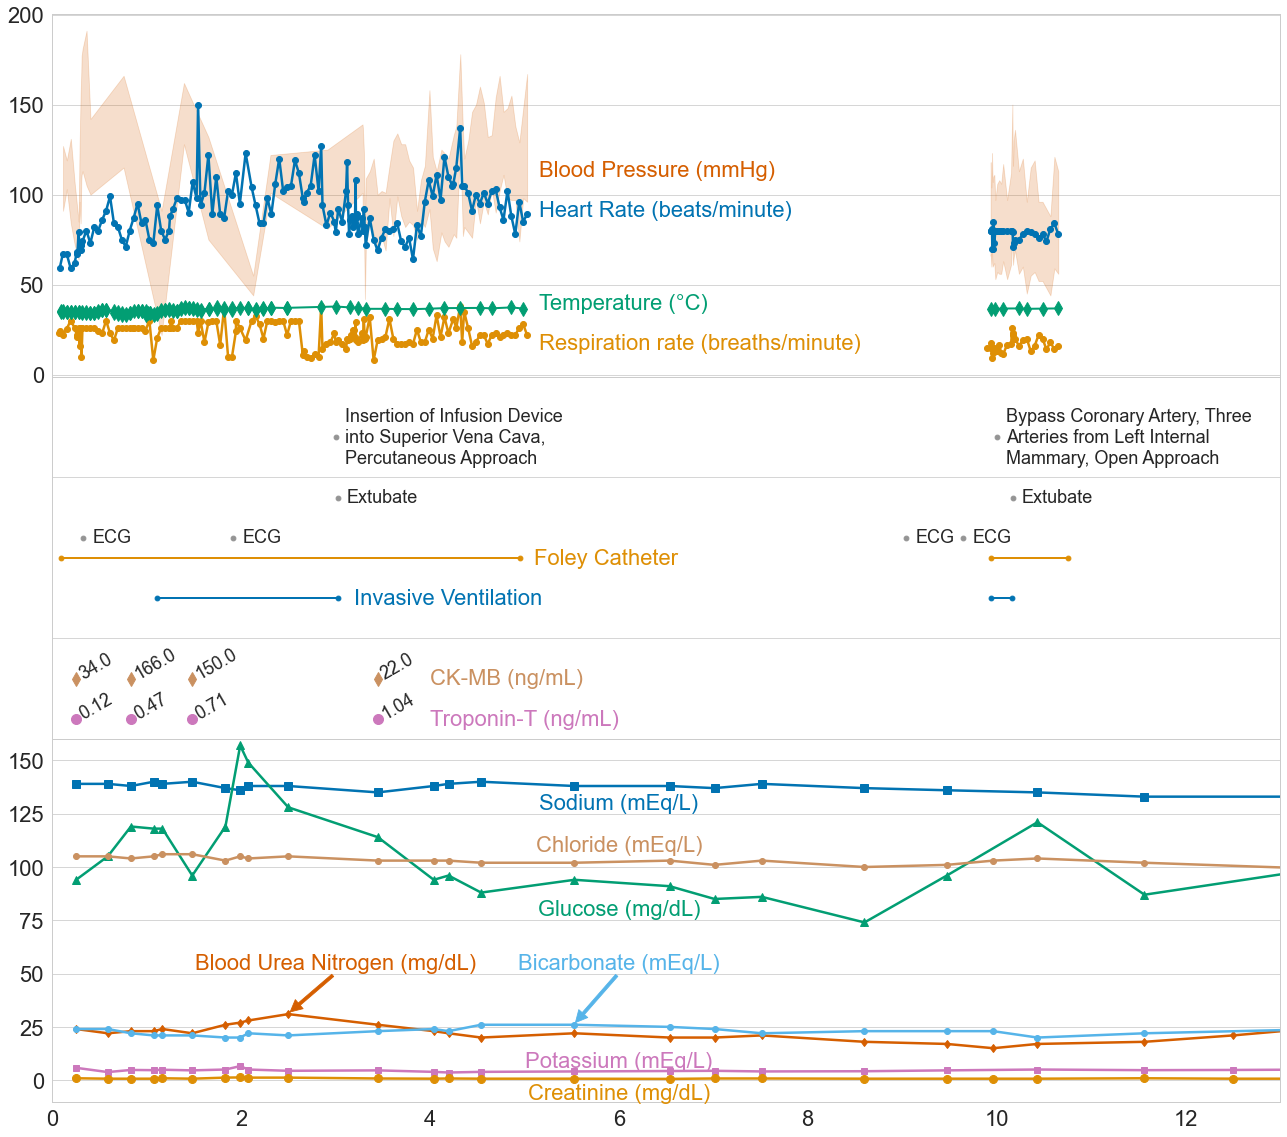

In [12]:
# convert times to a unit consistently
# base time is minutes, so 24*60 -> equiv to converting to days
TIME_COEF = 24*60.0
TIME_UNIT = 'days'

# to prevent a line being drawn between distinct ICU stays, we sometimes add a NaN row to data before plotting
null_time = 8*24*60

fig = plt.figure(figsize=(22, 20))
plt.rcParams.update({'font.size': 22})
gs = fig.add_gridspec(3, hspace=0)
ax0, ax1, ax2 = gs.subplots(sharex=True, sharey=False)

ax0.set_xlim([0, 13])

# === vital signs
plot_info_vitals = OrderedDict([
    ['heart_rate', {'label': 'Heart Rate', 'color': colors[0], 'marker': 'o', 'lw': 2.5, 'markersize': 6}],
    ['resp_rate', {'label': 'Respiratory Rate', 'color': colors[1], 'marker': 'o', 'lw': 2.5, 'markersize': 6}],
])
plot_numeric_data(ax0, vitals, plot_info_vitals, null_time=null_time)


# plot shaded dbp/sbp data
bp = vitals[['offset', 'dbp', 'sbp']].dropna().copy()
idx = bp['offset'] < null_time
plot_args = {'color': colors[3], 'alpha': 0.2}
# first half, before ICU discharge
ax0.fill_between(bp.loc[idx, 'offset']/TIME_COEF, bp.loc[idx, 'dbp'], bp.loc[idx, 'sbp'], label='Blood Pressure (mmHg)', **plot_args)
ax0.fill_between(bp.loc[~idx, 'offset']/TIME_COEF, bp.loc[~idx, 'dbp'], bp.loc[~idx, 'sbp'], **plot_args)

# plot temperature
idx = temp['offset'] < null_time
ax0.plot(temp.loc[idx, 'offset']/TIME_COEF, temp.loc[idx, 'valuenum'], label='Temperature (°C)', color=colors[2], marker='d', markersize=10, lw=2)
ax0.plot(temp.loc[~idx, 'offset']/TIME_COEF, temp.loc[~idx, 'valuenum'], color=colors[2], marker='d', markersize=10, lw=2)

# add the legend to the plot itself for better readability
x_loc = 5.15
ax0.text(x_loc, 110, 'Blood Pressure (mmHg)', color=colors[3])
ax0.text(x_loc, 88, 'Heart Rate (beats/minute)', color=colors[0])
ax0.text(x_loc, 36, 'Temperature (°C)', color=colors[2])
ax0.text(x_loc, 14, 'Respiration rate (breaths/minute)', color=colors[1])
ax0.grid(False, axis='x')

plot_info_cardiac = OrderedDict([
    ['troponin_t', {'label': 'Troponin-T', 'y_value': 0, 'color': colors[4], 'marker': 'o', 'markersize': 10}],
    ['ck_mb', {'label': 'CK-MB', 'y_value': 1, 'color': colors[5], 'marker': 'd', 'markersize': 10}],
])
plot_numeric_as_text(ax1, cardiac.iloc[0::2], plot_info_cardiac, null_time=null_time)

ax1.text(4, 0, 'Troponin-T (ng/mL)', va='center', color=colors[4])
ax1.text(4, 1, 'CK-MB (ng/mL)', va='center', color=colors[5])


# arctic sun
#plot_info_cooling = OrderedDict([
#    ['value', {'label': 'Arctic Sun (on)', 'color': colors[4], 'linewidth': 0, 'markersize': 6, 'marker': 'o'}],
#])
#cooling_plot = cooling.copy()
#cooling_plot['value'] = 2
#plot_numeric_data(ax1, cooling_plot, plot_info_cooling, null_time=null_time)


plot_info_pe = OrderedDict([
    # ['General Xray', {'y_value': 150, 'label': 'X-ray', 'color': colors[0], 'lw': 0, 'marker': 'o'}],
    ['Invasive Ventilation', {'y_value': 3, 'label': 'Ventilation', 'color': colors[0], 'lw': 2, 'marker': 'o'}],
    ['Foley Catheter', {'y_value': 4, 'label': 'Foley Catheter', 'color': colors[1], 'lw': 2, 'marker': 'o'}],
    #['Tubes/Drains', {'y_value': 170, 'label': 'Tubes/Drains', 'color': colors[1], 'lw': 0, 'marker': 'o'}],
])
plot_range_data(ax1, pe, plot_info_pe, null_time=null_time)

# labels for vent/foley
ax1.text(3.2, 3, 'Invasive Ventilation', va='center', color=colors[0])
ax1.text(5.1, 4, 'Foley Catheter', va='center', color=colors[1])

# POE events
plot_info_poe = OrderedDict([
    ['ECG', {'label': 'TBD', 'y_value': 4.5, 'marker': 'o', 'color': colors[7]}],
    ['Extubate', {'label': 'TBD', 'y_value': 5.5, 'marker': 'o', 'color': colors[7]}],
])
plot_text_data(ax1, poe, plot_info_poe, text_col='order_subtype', null_time=null_time, label_col='order_subtype')


proc_subset = proc.iloc[[0, 2]].copy().rename(columns={'long_title': 'value'})
plot_info_proc = OrderedDict([
    ['proc', {'label': 'Billed Procedures', 'y_value': 7, 'marker': 'o', 'color': colors[7]}],
])
plot_text_data(ax1, proc_subset, plot_info_proc, null_time=null_time)

ax1.set_ylim([-0.5, 8.5])


ax1.set_yticks([2, 6], ['', ''])
ax1.grid(False, axis='x')

# === blood gases
#plot_info_bg = OrderedDict([
#    ['pao2', {'label': 'PaO2', 'color': colors[3], 'marker': 'o', 'lw': 2.5, 'markersize': 6}],
#    ['paco2', {'label': 'PaCO2', 'color': colors[1], 'marker': 'o', 'lw': 2.5, 'markersize': 6}],
#])
# plot_numeric_data(ax2, bg, plot_info_bg, null_time=null_time)

plot_info_chem = OrderedDict([
    ['sodium', {'label': 'Sodium (mEq/L)', 'color': colors[0], 'marker': 's', 'lw': 2.5, 'markersize': 8}],
    ['potassium', {'label': 'Potassium (mEq/L)', 'color': colors[4], 'marker': 's', 'lw': 2.5, 'markersize': 6}],
    ['glucose', {'label': 'Glucose (mg/dL)', 'color': colors[2], 'marker': '^', 'lw': 2.5, 'markersize': 8}],
    ['bun', {'label': 'Blood Urea Nitrogen (mg/dL)', 'color': colors[3], 'marker': 'd', 'lw': 2.5, 'markersize': 6}],
    ['creatinine', {'label': 'Creatinine (mg/dL)', 'color': colors[1], 'marker': 'o', 'lw': 2.5, 'markersize': 8}],
    ['bicarbonate', {'label': 'Bicarbonate (mEq/L)', 'color': colors[9], 'marker': 'o', 'lw': 2.5, 'markersize': 6}],
    ['chloride', {'label': 'Chloride (mEq/L)', 'color': colors[5], 'marker': 'o', 'lw': 2.5, 'markersize': 6}],
])
plot_numeric_data(ax2, chem, plot_info_chem, null_time=None)

ax2.set_ylim([-10, 160])
# labels for chem7
lab_locs = OrderedDict([
    ['sodium', (6, 130)],
    ['potassium', (6, 8.8)],
    ['glucose', (6, 80)],
    ['bun', (3, 55)],
    ['creatinine', (6, -6)],
    ['bicarbonate', (6, 55)],
    ['chloride', (6, 110)],
])
for lab, (x_loc, y_loc) in lab_locs.items():
    label = plot_info_chem[lab]['label']
    color = plot_info_chem[lab]['color']
    # for bun / bicarbonate, we add an annotation line
    if lab in ('bun', 'bicarbonate'):
        if lab == 'bun':
            xy = (2.499 + 0.02, 31 + 1)
        else:
            xy = (5.52 + 0.02, 26 + 1)
        
        ax2.annotate(label, xy, (x_loc, y_loc), va='center', ha='center', color=color, arrowprops={'width': 3, 'color': color})
    else:
        ax2.text(x_loc, y_loc, label, va='center', ha='center', color=color)
        

ax2.grid(False, axis='x')

# save!
fig.savefig('mimiciv_example_patient.pdf', bbox_inches='tight')

## Medications

We plot different medication sources for the same patient to help visualize their overlap.

In [26]:
def add_offset_column(df, admittime, col='charttime', offset_col='offset', time_coef=24*60):
    df[offset_col] = ((pd.to_datetime(df[col]) - admittime) / np.timedelta64(1, 'm')) / time_coef

query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE hadm_id = {hadm_id}
"""
adm = pd.read_gbq(query, "lcp-internal").sort_values('admittime')
admittime = pd.to_datetime(adm.loc[0, 'admittime'])

query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.prescriptions`
WHERE hadm_id = {hadm_id}
"""
pr = pd.read_gbq(query, "lcp-internal").sort_values('starttime')
# subtract off admittime to create offset - operates on dataframe in-place
add_offset_column(pr, admittime, 'starttime', 'offset')
add_offset_column(pr, admittime, 'stoptime', 'stop_offset')
print(f'pr: {pr.columns}')


query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.pharmacy`
WHERE hadm_id = {hadm_id}
"""
ph = pd.read_gbq(query, "lcp-internal").sort_values('starttime')
# subtract off admittime to create offset - operates on dataframe in-place
add_offset_column(ph, admittime, 'starttime', 'offset')
add_offset_column(ph, admittime, 'stoptime', 'stop_offset')
print(f'ph: {ph.columns}')


query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.emar`
WHERE hadm_id = {hadm_id}
"""
emar = pd.read_gbq(query, "lcp-internal").sort_values('charttime')
add_offset_column(emar, admittime, 'charttime', 'offset')
print(f'emar: {emar.columns}')

query = f"""
SELECT det.*
FROM `physionet-data.mimiciv_hosp.emar_detail` det
INNER JOIN `physionet-data.mimiciv_hosp.emar` e
  ON det.emar_id = e.emar_id
WHERE e.hadm_id = {hadm_id}
"""
emardet = pd.read_gbq(query, "lcp-internal").sort_values('emar_seq')
print(f'emardet: {emardet.columns}')

query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.inputevents`
WHERE hadm_id = {hadm_id}
"""
inp = pd.read_gbq(query, "lcp-internal").sort_values('starttime')
add_offset_column(inp, admittime, 'starttime', 'offset')
add_offset_column(inp, admittime, 'endtime', 'stop_offset')
print(f'inp: {inp.columns}')

# Load transfers
query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.transfers` tr
WHERE hadm_id = {hadm_id}
"""
tr = pd.read_gbq(query, "lcp-internal").sort_values('intime')

add_offset_column(tr, admittime, 'intime', 'in_offset')
add_offset_column(tr, admittime, 'outtime', 'out_offset')


#=== merge emar dataframes to simplify plot, focus on heparin/enoxaparin
idx = emar['medication'].isin(['Heparin', 'Enoxaparin Sodium'])
df_emar = emar.loc[idx].copy()

# dose due is in the "parent" of the emar detail group
# where parent_field_ordinal is null
# only 1 of these per emar_id
idx = emardet['parent_field_ordinal'].isnull()
cols = [
  'emar_id', 'administration_type', 'dose_due', 'dose_due_unit',
  'complete_dose_not_given', 'will_remainder_of_dose_be_given'
]
df_emar = df_emar.merge(emardet.loc[idx, cols], on='emar_id', how='left')
df_emar['dose_due'] = pd.to_numeric(df_emar['dose_due'])

# add in the actual dose administered
# since it can be across multiple formulary doses (e.g. multiple pills)
# we aggregate the detail table
# in heparin/enoxaparin case, we are probably aggregating over a single adm
# note that for heparin, since it's a continuous infusion, dose_given is 0/None
idx = emardet['parent_field_ordinal'].notnull()
cols = ['emar_id', 'dose_given', 'dose_given_unit', 'product_amount_given', 'product_unit']
em = emardet.loc[idx, cols].copy()

# re-cast columns - sometimes drugs have string doses
em['dose_given'] = pd.to_numeric(em['dose_given'], errors='coerce')
em['product_amount_given'] = pd.to_numeric(em['product_amount_given'], errors='coerce')

em = em.groupby('emar_id').agg(
  dose_given=pd.NamedAgg(column='dose_given', aggfunc='sum'),
  dose_given_unit=pd.NamedAgg(column='dose_given_unit', aggfunc='max'),
  product_amount_given=pd.NamedAgg(column='product_amount_given', aggfunc='sum'),
  product_unit=pd.NamedAgg(column='product_unit', aggfunc='max'),
)

df_emar = df_emar.merge(em, on='emar_id', how='left')
df_emar.sort_values(['charttime', 'emar_seq'], inplace=True)

pr: Index(['subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'poe_seq',
       'starttime', 'stoptime', 'drug_type', 'drug', 'formulary_drug_cd',
       'gsn', 'ndc', 'prod_strength', 'form_rx', 'dose_val_rx', 'dose_unit_rx',
       'form_val_disp', 'form_unit_disp', 'doses_per_24_hrs', 'route',
       'offset', 'stop_offset'],
      dtype='object')
ph: Index(['subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'starttime',
       'stoptime', 'medication', 'proc_type', 'status', 'entertime',
       'verifiedtime', 'route', 'frequency', 'disp_sched', 'infusion_type',
       'sliding_scale', 'lockout_interval', 'basal_rate', 'one_hr_max',
       'doses_per_24_hrs', 'duration', 'duration_interval', 'expiration_value',
       'expiration_unit', 'expirationdate', 'dispensation', 'fill_quantity',
       'offset', 'stop_offset'],
      dtype='object')
emar: Index(['subject_id', 'hadm_id', 'emar_id', 'emar_seq', 'poe_id', 'pharmacy_id',
       'charttime', 'medication', 'event_txt', 'scheduletim

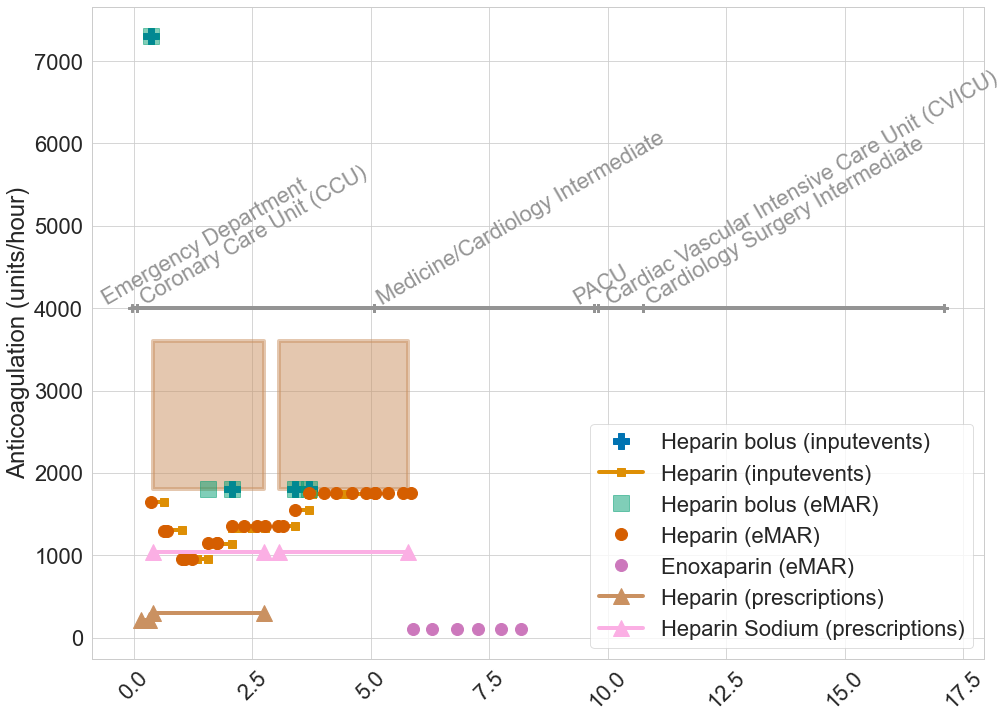

In [17]:
plt.figure(figsize=[16, 12])

# ICU documentation (inputevents) of heparin administration
inp_labels = {
  225152: 'Heparin (inputevents)'
}

for itemid, label in inp_labels.items():
    idx = inp['itemid'] == itemid
    dff = inp.loc[idx].sort_values('offset')
    # first, plot bolus heparin
    idx = dff['rate'].isnull()
    plt.plot(dff.loc[idx, 'offset'], dff.loc[idx, 'amount'], 'P', markersize=16, color=colors[0], label='Heparin bolus (inputevents)')

    for i, row in dff.iterrows():
        rate = pd.to_numeric(row['rate'])
        plt.plot([row['offset'], row['stop_offset']], [rate, rate], 's-', markersize=8, linewidth=4, color=colors[1], label=label)
        # disable legend plotting in future rows
        label = '__no_legend__'
    # plt.fill_between([row['starttime'], row['endtime']], [0, 0], [rate, rate], color='#fc8d62', alpha=0.8)

# eMAR documentation of heparin
med = 'Heparin'
idx_med = (df_emar['medication'] == med)
# first, plot bolus separately
idx = idx_med & (df_emar['administration_type'] == 'Heparin IV Bolus')
plt.plot(df_emar.loc[idx, 'offset'], df_emar.loc[idx, 'dose_due'], 's', color=colors[2], markersize=16, alpha=0.5, label='Heparin bolus (eMAR)')

idx = idx_med & (df_emar['administration_type'] != 'Heparin IV Bolus')
plt.plot(df_emar.loc[idx, 'offset'], df_emar.loc[idx, 'dose_due'], 'o', color=colors[3], markersize=12, label='Heparin (eMAR)')

# enoxaparin
med = 'Enoxaparin Sodium'
idx = (df_emar['medication'] == med)
plt.plot(df_emar.loc[idx, 'offset'], df_emar.loc[idx, 'dose_due'], 'o', color=colors[4], markersize=12, label='Enoxaparin (eMAR)')


# prescriptions documentation of heparin
meds = ['Heparin', 'Heparin Sodium']
med_colors = {
    'Heparin': colors[5],
    'Heparin Sodium': colors[6],
    'Enoxaparin Sodium': colors[7]
}
idx = pr['drug'].isin(meds)
df = pr.loc[idx].copy()

for med in meds:
    label = med + ' (prescriptions)'
    color = med_colors[med]
    idx = df['drug'] == med
    n = 0
    for i, row in df.loc[idx].iterrows():
        if n > 0:
          # do not add to the legend if we have already plotted at least once
          med = '__no_legend__'

        xi = [row['offset'], row['stop_offset']]
        dose = row['dose_val_rx']
        if '-' in dose:
            # plot upper/lower ranges
            dose_lower, dose_upper = dose.split('-')
            dose_lower = int(dose_lower)
            dose_upper = int(dose_upper)
            plt.fill_between(xi, [dose_lower, dose_lower], [dose_upper, dose_upper], linewidth=4, color=color, alpha=0.5, label=label)
        else:
            dose = pd.to_numeric(dose.replace(',', ''))
            dose = dose / 24
            plt.plot(xi, [dose, dose], '^-', linewidth=4, markersize=16, color=color, label=label)
        label = '__no_legend__'

        n += 1

# plot their ICU stay
yloc = 4000
for i, row in tr.iterrows():
    plt.plot([row['in_offset'], row['out_offset']], [yloc, yloc], 'P-', linewidth=4, markersize=8, color=colors[7])
    xloc = row['in_offset']
    if row['careunit'] is None:
        continue

    if row['careunit'] == 'Emergency Department':
        xloc -= 0.7
    elif row['careunit'] == 'PACU':
        xloc -= 0.5
    elif 'CVICU' in row['careunit']:
        xloc += 0.1
    plt.text(xloc, yloc, row['careunit'], rotation=30, va='bottom', color=colors[7])
    #if ('CCU' in row['careunit']) or ('ICU' in row['careunit']):
    # plt.fill_between([row['in_offset'], row['out_offset']], [0, 0], [upper, upper], color='#ababab', alpha=0.2)

plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.ylabel('Anticoagulation (units/hour)')

plt.savefig('mimiciv_medication.pdf', bbox_inches='tight')
plt.show()

## Most frequent diagnoses

In [18]:
# Table 2 Most frequent diagnoses as coded using the ICD codes.
query = """
WITH grp AS
(
SELECT a.hadm_id
, CASE WHEN icu.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_icu_admit
, CASE WHEN dia.seq_num > 1 THEN 0 ELSE 1 END AS primary_dx
, dia.icd_code
, dia.icd_version
, d_dx.long_title
FROM `lcp-internal.mimic_hosp.admissions` a
LEFT JOIN `lcp-internal.mimic_hosp.diagnoses_icd` dia ON a.hadm_id = dia.hadm_id
LEFT JOIN `lcp-internal.mimic_hosp.d_icd_diagnoses` d_dx ON dia.icd_code = d_dx.icd_code AND dia.icd_version = d_dx.icd_version
-- join to icustays and flag those which have an ICU stay
LEFT JOIN ( SELECT DISTINCT hadm_id FROM `lcp-internal.mimic_icu.icustays` ) icu ON a.hadm_id = icu.hadm_id
)
SELECT has_icu_admit, primary_dx, icd_code, icd_version, long_title
, COUNT(*) AS n
FROM grp
GROUP BY 1, 2, 3, 4, 5
"""

dx = pd.read_gbq(query, "lcp-internal")
dx.head()

,has_icu_admit,primary_dx,icd_code,icd_version,long_title,n
0,0,1,29420,9.0,"Dementia, unspecified, without behavioral dist...",63
1,0,0,V6284,9.0,Suicidal ideation,7970
2,0,0,2979,9.0,Unspecified paranoid state,68
3,0,0,30500,9.0,"Alcohol abuse, unspecified",6223
4,0,0,2809,9.0,"Iron deficiency anemia, unspecified",6054


In [19]:
idx = dx['has_icu_admit'] == 1
print('Top 10 dx for stays with an ICU admission:')
grp = dx.loc[idx].groupby(['icd_code', 'long_title'])[['n']].sum().sort_values('n', ascending=False)
display(grp.head(n=10))

print('Top 10 dx for stays without an ICU admission:')
grp = dx.loc[~idx].groupby(['icd_code', 'long_title'])[['n']].sum().sort_values('n', ascending=False)
display(grp.head(n=10))

idx = (dx['has_icu_admit'] == 1) & (dx['primary_dx'] == 1)
print('Top 10 *primary* dx for stays with an ICU admission:')
grp = dx.loc[idx].groupby(['icd_code', 'long_title'])[['n']].sum().sort_values('n', ascending=False)
display(grp.head(n=10))

idx = (dx['has_icu_admit'] == 0) & (dx['primary_dx'] == 1)
print('Top 10 *primary* dx for stays without an ICU admission:')
grp = dx.loc[idx].groupby(['icd_code', 'long_title'])[['n']].sum().sort_values('n', ascending=False)
display(grp.head(n=10))

Top 10 dx for stays with an ICU admission:


,,n
icd_code,long_title,
4019,Unspecified essential hypertension,17489
2724,Other and unspecified hyperlipidemia,13443
E785,"Hyperlipidemia, unspecified",11659
42731,Atrial fibrillation,10950
I10,Essential (primary) hypertension,10627
4280,"Congestive heart failure, unspecified",10250
41401,Coronary atherosclerosis of native coronary artery,9666
Z87891,Personal history of nicotine dependence,9067
5849,"Acute kidney failure, unspecified",8812


Top 10 dx for stays without an ICU admission:


,,n
icd_code,long_title,
4019,Unspecified essential hypertension,85032
2724,Other and unspecified hyperlipidemia,53899
I10,Essential (primary) hypertension,43766
53081,Esophageal reflux,40959
E785,"Hyperlipidemia, unspecified",39379
25000,"Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled",35644
Z87891,Personal history of nicotine dependence,31704
311,"Depressive disorder, not elsewhere classified",31210
K219,Gastro-esophageal reflux disease without esophagitis,28961


Top 10 *primary* dx for stays with an ICU admission:


,,n
icd_code,long_title,
0389,Unspecified septicemia,2290
41401,Coronary atherosclerosis of native coronary artery,2112
A419,"Sepsis, unspecified organism",1884
4241,Aortic valve disorders,1162
41071,"Subendocardial infarction, initial episode of care",1041
I214,Non-ST elevation (NSTEMI) myocardial infarction,892
431,Intracerebral hemorrhage,822
I2510,Atherosclerotic heart disease of native coronary artery without angina pectoris,790
51881,Acute respiratory failure,773


Top 10 *primary* dx for stays without an ICU admission:


,,n
icd_code,long_title,
78650,"Chest pain, unspecified",7320
78659,Other chest pain,5199
30500,"Alcohol abuse, unspecified",4577
41401,Coronary atherosclerosis of native coronary artery,3630
311,"Depressive disorder, not elsewhere classified",3567
486,"Pneumonia, organism unspecified",3165
5849,"Acute kidney failure, unspecified",3149
F329,"Major depressive disorder, single episode, unspecified",3045
V5811,Encounter for antineoplastic chemotherapy,2914


### Data completion for ICU stays

In [21]:
query = """
SELECT a.hadm_id
, CASE WHEN icu.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_icu_stay
,tra.n AS n_transfers
,dia.n AS n_diagnoses_icd
,drg.n AS n_drgcodes
,ema.n AS n_emar
,hcp.n AS n_hcpcsevents
,lab.n AS n_labevents
,mic.n AS n_microbiologyevents
,omr.n AS n_omr
,pha.n AS n_pharmacy
,poe.n AS n_poe
,pre.n AS n_prescriptions
,pro.n AS n_procedures_icd
,ser.n AS n_services
FROM `lcp-internal.mimic_hosp.admissions` a
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.transfers` GROUP BY hadm_id ) tra ON a.hadm_id = tra.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.diagnoses_icd` GROUP BY hadm_id ) dia ON a.hadm_id = dia.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.drgcodes` GROUP BY hadm_id ) drg ON a.hadm_id = drg.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.emar` GROUP BY hadm_id ) ema ON a.hadm_id = ema.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.hcpcsevents` GROUP BY hadm_id ) hcp ON a.hadm_id = hcp.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.labevents` GROUP BY hadm_id ) lab ON a.hadm_id = lab.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.microbiologyevents` GROUP BY hadm_id ) mic ON a.hadm_id = mic.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.pharmacy` GROUP BY hadm_id ) pha ON a.hadm_id = pha.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.poe` GROUP BY hadm_id ) poe ON a.hadm_id = poe.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.prescriptions` GROUP BY hadm_id ) pre ON a.hadm_id = pre.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.procedures_icd` GROUP BY hadm_id ) pro ON a.hadm_id = pro.hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.services` GROUP BY hadm_id ) ser ON a.hadm_id = ser.hadm_id
-- below table needs a join to hadm_id
LEFT JOIN ( SELECT hadm_id, COUNT(*) AS N FROM `lcp-internal.mimic_hosp.omr` t INNER JOIN `lcp-internal.mimic_hosp.admissions` adm ON t.subject_id = adm.subject_id AND t.chartdate BETWEEN adm.admittime AND adm.dischtime GROUP BY hadm_id ) omr ON a.hadm_id = omr.hadm_id
-- join to icustays and flag those which have an ICU stay
LEFT JOIN ( SELECT DISTINCT hadm_id FROM `lcp-internal.mimic_icu.icustays` ) icu ON a.hadm_id = icu.hadm_id
"""

tbl_count = pd.read_gbq(query, "lcp-internal")
tbl_count.set_index('hadm_id', inplace=True)
# fill empty values with 0 -> no observations found
for col in tbl_count.columns:
    tbl_count[col] = tbl_count[col].fillna(0)
    tbl_count[col] = tbl_count[col].astype(int)

tbl_count.head()

,has_icu_stay,n_transfers,n_diagnoses_icd,n_drgcodes,n_emar,n_hcpcsevents,n_labevents,n_microbiologyevents,n_omr,n_pharmacy,n_poe,n_prescriptions,n_procedures_icd,n_services
hadm_id,,,,,,,,,,,,,,
22942076,1,4,10,2,0,0,313,7,0,40,123,63,3,1
20668418,0,6,14,2,0,0,411,1,0,104,218,113,8,2
21095812,1,2,25,2,0,0,2260,118,0,251,743,302,7,1
22580355,1,2,20,2,0,0,1628,184,0,284,781,336,8,1
25020332,0,2,11,2,113,0,63,6,0,25,65,26,7,1


In [22]:
table_list = tbl_count.columns[1:]
tbl_agg = pd.DataFrame(index=table_list)

tbl_agg['Data completion'] = (tbl_count > 0).sum()
N = tbl_count.shape[0]
tbl_agg['Data completion'] = tbl_agg['Data completion'].apply(lambda x: f'{x:,} ({x/N:3.2%})')

# iterate over 3 quantile values and output to the table
quantiles_cols = [[0.05, '5th percentile'], [0.5, 'Median number of observations'], [0.95, '95th percentile']]
for q, quantile_col_name in quantiles_cols:
    tbl_agg[quantile_col_name] = 0
    for col in table_list:
        idx = tbl_count[col] > 0
        tbl_agg.loc[col, quantile_col_name] = tbl_count.loc[idx, col].quantile(q)


# repeat for ICU stays

idx_icu = tbl_count['has_icu_stay'] == 1

tbl_agg['No data (ICU subset)'] = 0
for col in table_list:
    tbl_agg.loc[col, 'No data (ICU subset)'] = (tbl_count.loc[idx_icu, col] > 0).sum()

N = idx_icu.sum()
tbl_agg['No data (ICU subset)'] = tbl_agg['No data (ICU subset)'].apply(lambda x: f'{x:,} ({x/N:3.2%})')

for q, quantile_col_name in quantiles_cols:
    quantile_col_name += ' (ICU subset)'
    tbl_agg[quantile_col_name] = 0
    for col in table_list:
        idx = (tbl_count[col] > 0) & (idx_icu)
        tbl_agg.loc[col, quantile_col_name] = tbl_count.loc[idx, col].quantile(q)

tbl_agg.index = [c[2:] for c in tbl_agg.index]
tbl_agg

,Data completion,5th percentile,Median number of observations,95th percentile,No data (ICU subset),5th percentile (ICU subset),Median number of observations (ICU subset),95th percentile (ICU subset)
transfers,"454,324 (100.00%)",2,3,6,"69,639 (100.00%)",3,5,9
diagnoses_icd,"453,925 (99.91%)",2,10,25,"69,618 (99.97%)",5,16,33
drgcodes,"328,381 (72.28%)",1,2,2,"69,029 (99.12%)",2,2,2
emar,"175,065 (38.53%)",9,73,505,"34,675 (49.79%)",18,175,1034
hcpcsevents,"125,350 (27.59%)",1,1,3,589 (0.85%),1,1,3
labevents,"369,601 (81.35%)",11,84,583,"69,036 (99.13%)",49,259,1349
microbiologyevents,"172,662 (38.00%)",1,3,32,"58,171 (83.53%)",1,4,47
omr,"60,845 (13.39%)",2,3,6,"4,056 (5.82%)",1,3,8
pharmacy,"384,772 (84.69%)",9,25,105,"69,497 (99.80%)",18,62,196
poe,"448,026 (98.61%)",12,60,276,"69,167 (99.32%)",57,179,628
